## I generated my jobs over a few different notebooks which I consolidated into this single notebook. The first parts of this notebook include all of the jobs that I used to generate the plots as well as the function to extract the fits and get the data. 

## The second part of the notebook includes the code that was used to run each job and examples for how to run the code to generate all of the jobs. 

## The code here was used to generate the data for doing AC stark shift measurments as well as driving the cavity to see the qubit being excited to higher excitation states. The code here corresponds with sections 3 and 4 of the project as well as the appendix

-Jeronimo Martinez

In [312]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt

# do this so that when call backend, will look nice, report properties

%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# check qiskit version
import qiskit
qiskit.__qiskit_version__
# make sure the version is up to date!

ibmqfactory.load_account:WARNING:2021-05-10 17:14:52,186: Credentials are already in use. The existing account in the session will be replaced.


{'qiskit-terra': '0.17.0', 'qiskit-aer': '0.8.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.0', 'qiskit': '0.25.0'}

In [313]:
# basic unit conversion factors and device properties

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
scale_factor = 1e-14 # scale factor to remove factors of 10 from the data

# basic parameters
qubit = 0 # there is only one qubit
dt = backend_config.dt
#defaults
backend_defaults = backend.defaults()

# drive parameters
[[min_drive_freq, max_drive_freq]] = backend_config.qubit_lo_range # range of freqs for qubit drive, 1Ghz around wq
[[min_meas_freq, max_meas_freq]] = backend_config.meas_lo_range # range of freqs for measurement drive

# cavity parameters
cavity_freq = backend_defaults.meas_freq_est[qubit]

# qubit parameters
qubit_props_dict = backend.properties().qubit_property(0)
qubit_freq = qubit_props_dict['frequency'][0]
qubit_T1 = qubit_props_dict['T1'][0]
qubit_T2 = qubit_props_dict['T2'][0]
qubit_anharm = qubit_props_dict['anharmonicity'][0]

print(f"sampling time: {dt / ns : .2f} ns.")
print(f"Max eperiments, max shots: {backend_config.max_experiments}, {backend_config.max_shots}")
print(f"qubit frequency: {qubit_freq / GHz} GHz.")
print(f"qubit decay: {1 /(qubit_T1* MHz)} MHz.")
print(f"qubit dephase: {1 /(qubit_T1* MHz)} MHz.")
print(f"qubit anharmonicity: {qubit_anharm / GHz} GHz.")

print(f"cavity frequency: {cavity_freq / GHz} GHz.")
# qubit_props_dict # other interesting parameters

sampling time:  0.22 ns.
Max eperiments, max shots: 75, 8192
qubit frequency: 4.97186208283383 GHz.
qubit decay: 0.006264871386576632 MHz.
qubit dephase: 0.006264871386576632 MHz.
qubit anharmonicity: -0.3471929314828262 GHz.
cavity frequency: 6.993370669 GHz.


In [314]:
# defaults and other parameters used to define control pulses
from qiskit import pulse, assemble
from qiskit.pulse import Play, library# comment out if qiskit-terra vesrion less than 0.13.0
from qiskit.pulse import  GaussianSquare
from scipy.optimize import curve_fit

# useful helper functions
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def get_job_data(job, qubit = 0, scale_factor = 1e-14):
    # helper function to get data from jobs
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if job_results.results[0].meas_return == 'avg': # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data


# lorentzian function
def lorentzian(f, f0, k, a, offs):
    """-a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs"""
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000) 
    y_fit = function(x_values, *fitparams)
    perr = np.sqrt(np.diag(conv))
    return fitparams, y_fit, perr



def get_frequency(amplitude,linear_scaling = 100,  center_frequency = 4971855446.282341 , spread = 40*MHz, num_points = 41):
    center_middle = center_frequency - linear_scaling*MHz*amplitude
    frequency_min = center_middle - spread / 2
    frequency_max = center_middle + spread / 2
    
    frequency_range = np.linspace(frequency_min, frequency_max, num_points)
    
    return(frequency_range)



def plotting_values(job, frequency_values):
    frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])

    plt.scatter(frequency_values/GHz, np.real(sweep_values), color='black') # plot real part of sweep values
    plt.xlim([min(frequency_values/GHz), max(frequency_values/GHz)])
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured signal [a.u.]")
    plt.show()

def lorentzian_fit(job, frequency_values, guesses = None):
    
    frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])
        
    sweep_values = np.real(np.array(sweep_values))
        
    if guesses == None:
        frequency_guess = frequency_values[int(len(frequency_values)/2)]
        offset = sweep_values[0]
        difference_max = abs(max(sweep_values) - offset)
        difference_min = abs(offset - min(sweep_values))
        if difference_min > difference_max:
            amplitude = -1*difference_min*1e-2
        else:
            amplitude = difference_max*1e-2
        linewidth = 2e-3  #in MHz
    
    else:
        amplitude, frequency_guess, linewidth, offset = guesses
        
    #print(amplitude, frequency_guess, linewidth, offset)
        
    fit_params, y_fit, yerr = fit_function(frequency_values,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [amplitude, frequency_guess, linewidth, offset] # initial parameters for curve_fit
                                )  
    #plt.scatter(frequency_values, np.real(sweep_values), color='black') # plot real part of sweep values

    return(fit_params, y_fit, yerr)

def plot_w_fit(job, frequencies):
    
    frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])
        

    fit_params, y_fit ,yerr = lorentzian_fit(job, frequencies)

    #print(fit_params, yerr)
    print(r'Frequency: %5.5f $\pm$ %5.5f GHz' %(fit_params[1], yerr[1]))
    print(r'Linewidth: %5.5f $\pm$ %5.5f MHz' %(fit_params[2]*1e3, yerr[2]*1e3))


    plt.scatter(frequencies, np.real(sweep_values), color='black')
    plt.plot(frequencies, y_fit, color='red')
    plt.xlim([min(frequencies), max(frequencies)])

    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured Signal [a.u.]")
    plt.show()

def get_values(job):
    frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])
        
    return(sweep_values)

def exponential(x, A, B, C):
    return(A* np.exp(-x / B) + C)


# Starting section
## Measuring qubit frequency as function of cavity ringdown time

In [315]:
job0_1 = backend.retrieve_job('60873078ccde7761d1715953')
job05_1 = backend.retrieve_job('608730d1e3c6c2736c2d6ffa')
job05_2 = backend.retrieve_job('6087314abc6ddf7321f7283a')
job05_3 = backend.retrieve_job('608731a3ccde77e12a71595b')
job05_4 = backend.retrieve_job('608731ece97f5c29f01181f8')
job05_5 = backend.retrieve_job('6087454c7fb842d263707f35')
job05_6 = backend.retrieve_job('6087454feec2f3f36e21106c')
job05_7 = backend.retrieve_job('60874557e3c6c217aa2d707e')
job05_8 = backend.retrieve_job('6087455a6455fe0d35190204')
job05_9 = backend.retrieve_job('6087455dbc6ddfb51bf728b4')
job05_10 = backend.retrieve_job('6087592f7dda91486afcc0fe')
job05_11 = backend.retrieve_job('608759327dda917e76fcc0ff')
job05_12 = backend.retrieve_job('60875935e3c6c203d12d70ff')
job05_13 = backend.retrieve_job('608759387dda914c85fcc100')
job05_14 = backend.retrieve_job('6087593b98e451081934bac4')


In [316]:
amplitude = 0.5
frequencies0_1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9, spread = 32*MHz)
frequencies05_1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.968e9, spread = 32*MHz)
frequencies05_2 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.955e9, spread = 32*MHz)
frequencies05_3 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.938e9, spread = 32*MHz)
frequencies05_4 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.922e9, spread = 32*MHz)
frequencies05_5 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.908e9, spread = 32*MHz)
frequencies05_6 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.896e9, spread = 32*MHz)
frequencies05_7 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.885e9, spread = 32*MHz)
frequencies05_8 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.878e9, spread = 32*MHz)
frequencies05_9 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.875e9, spread = 32*MHz)
frequencies05_10 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.871e9, spread = 32*MHz)
frequencies05_11 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_12 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_13 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_14 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)


In [318]:
all_jobs = [job0_1, job05_1, job05_2, job05_3, job05_4, job05_5, job05_6, job05_7, job05_8,
           job05_9, job05_10, job05_11, job05_12, job05_13, job05_14]
all_frequencies = [frequencies0_1, frequencies05_1, frequencies05_2, frequencies05_3, frequencies05_4, 
                  frequencies05_5, frequencies05_6, frequencies05_7, frequencies05_8, frequencies05_9,
                  frequencies05_10, frequencies05_11, frequencies05_12, frequencies05_13, frequencies05_14]

In [319]:
all_fit_values = []
for job, freq in zip(all_jobs, all_frequencies):
    all_fit_values.append((lorentzian_fit(job, freq/1e9)))

In [320]:
qubit_frequencies = []
q_freq_error = []
qubit_linewidth = []
q_linewidth_error = []
for fit in all_fit_values:
    fits = fit[0]
    error = fit[2]
    print(str(fits[1]) + ' with error ' + str(error[1]) + ' GHz')
    print(str(fits[2]) + ' with error ' + str(error[2]) + ' MHz')
    qubit_frequencies.append(fits[1])
    q_freq_error.append(error[1])
    qubit_linewidth.append(fits[2])
    q_linewidth_error.append(error[2])

    print()

4.971795702850506 with error 5.257424182800024e-05 GHz
0.0015254527914460214 with error 8.711206597235445e-05 MHz

4.96839174400506 with error 6.403498104378979e-05 GHz
0.001683000919862324 with error 0.0001084052461222171 MHz

4.955083352428548 with error 7.955069960730495e-05 GHz
0.0014895104226539356 with error 0.00012993041603571982 MHz

4.938406260726842 with error 0.0001470553094534632 GHz
0.002178778434749378 with error 0.0002625056515945044 MHz

4.921531033621728 with error 7.430155273409618e-05 GHz
0.0024402053690909227 with error 0.00013678161850562922 MHz

4.9065782603395505 with error 0.0001568351120723655 GHz
0.0029353529368839216 with error 0.000305992830896996 MHz

4.894366603253398 with error 0.00014701867029748468 GHz
0.002445062145928126 with error 0.0002702687487386635 MHz

4.88538642625631 with error 0.0001312163328610993 GHz
0.00282521909146706 with error 0.0002531226630252666 MHz

4.878544830134093 with error 0.0001928562963440869 GHz
0.002921528110770107 with err

In [9]:
fit_params_exp, y_fit_exp, yerr = fit_function(np.array(range(2, 15)),
                                 np.array(qubit_frequencies[2:]), 
                                 lambda x, A, B, C: A* np.exp(-x / B) + C,
                                 [1, 4, 4.86])

print(fit_params_exp, yerr)

[0.16642814 3.55300006 4.86387067] [0.00902357 0.31577422 0.00249567]


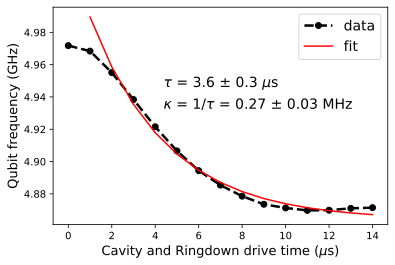

In [11]:
fig, axe = plt.subplots(1, 1, figsize=(6, 4))
    
#axe.scatter((np.array(frequency_scans) - cavity_frequency)/1e3, [1]*len(frequency_scans))
axe.plot(range(15), qubit_frequencies, '--o', label = 'data', color = 'black', linewidth = 2.5) #, np.array(q_freq_error))


#lt.scatter(drive_freqs, ground_spec_amp_strong, color='black') # plot real part of sweep values
axe.plot(range(1, 15), [exponential(freq,fit_params_exp[0], fit_params_exp[1], fit_params_exp[2]) 
                   for freq in range(1, 15)], color = 'red', label = 'fit')

#plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
#plt.title('Qubit Frequency for 0.5 Amplitude Drive Strength')
plt.xlabel("Cavity and Ringdown drive time ($\mu$s)", fontsize = 13)
plt.ylabel("Qubit frequency (GHz)", fontsize = 13)
plt.text(0.33, 0.65, r'$\tau$ = ' +  str(round(fit_params_exp[1], 1)) + ' $\pm$ ' + str(round(yerr[1], 1)) + ' $\mu$s', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
plt.text(0.33, 0.55, r'$\kappa$ = 1/$\tau$ = 0.27 $\pm$ 0.03 MHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)

plt.legend(fontsize = 14)         
#plt.savefig('cavity_drive.png')
         
plt.show()

# End section

# Start section
## Decde on 10us for resonator time now go AC stark shift

In [12]:
jobamp0 = backend.retrieve_job('60881c341c308d55c793fda9')
jobamp01 = backend.retrieve_job('6087913f98e451744d34bc72')
jobamp02 = backend.retrieve_job('60881c38ab16872ef0b2b3c5')
jobamp03 = backend.retrieve_job('60881c3a4cecff101977936a')
jobamp04 = backend.retrieve_job('60881c407b8db83f4c1360cc')
jobamp05 = backend.retrieve_job('60884c89cdf7ce40eb8c274c')
jobamp06 = backend.retrieve_job('60885b2bcdf7ce7d3b8c27b3')
jobamp07 = backend.retrieve_job('608806b9bc6ddfc436f72e4a')
jobamp08 = backend.retrieve_job('60884cc4edd54bf4acbd85c6')
jobamp09 = backend.retrieve_job('60885b60ffa8d962f6ae2059')
jobamp1 = backend.retrieve_job('60884cebedd54b8228bd85c8')

In [13]:
frequenciesamp0 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9, spread = 32*MHz)
frequenciesamp01 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 5*MHz, spread = 32*MHz)
frequenciesamp02 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 19*MHz, spread = 32*MHz)
frequenciesamp03 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 42*MHz, spread = 32*MHz)
frequenciesamp04 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 70*MHz, spread = 32*MHz)
frequenciesamp05 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 100*MHz, spread = 32*MHz)
frequenciesamp06 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 125*MHz, spread = 32*MHz)
frequenciesamp07 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 150*MHz, spread = 32*MHz)
frequenciesamp08 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 167*MHz, spread = 32*MHz)
frequenciesamp09 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 187*MHz, spread = 32*MHz)
frequenciesamp1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 193*MHz, spread = 32*MHz)


In [14]:
jobamp_all = [jobamp0, jobamp01, jobamp02, jobamp03, jobamp04, jobamp05, jobamp06, jobamp07, jobamp08, 
             jobamp09, jobamp1]

frequenciesamp_all = [frequenciesamp0, frequenciesamp01, frequenciesamp02, frequenciesamp03, frequenciesamp04, 
                     frequenciesamp05, frequenciesamp06, frequenciesamp07, frequenciesamp08, frequenciesamp09,
                     frequenciesamp1]

In [16]:
ampall_fit_values = []
for job, freq in zip(jobamp_all, frequenciesamp_all):
    ampall_fit_values.append((lorentzian_fit(job, freq/1e9)))

In [17]:
ampqubit_frequencies = []
ampq_freq_error = []
ampqubit_linewidth = []
ampq_linewidth_error = []
for fit in ampall_fit_values:
    fits = fit[0]
    error = fit[2]
    print(str(fits[1]) + ' with error ' + str(error[1]) + ' GHz')
    print(str(fits[2]) + ' with error ' + str(error[2]) + ' MHz')
    ampqubit_frequencies.append(fits[1])
    ampq_freq_error.append(error[1])
    ampqubit_linewidth.append(fits[2])
    ampq_linewidth_error.append(error[2])

    print()

4.971734746901781 with error 5.904200100485153e-05 GHz
0.0015817900865156217 with error 9.877520114470184e-05 MHz

4.967016059451807 with error 7.2649119861857e-05 GHz
0.0016570601586237174 with error 0.00012152690977104526 MHz

4.953169142823368 with error 6.649622270913025e-05 GHz
0.00187248098732171 with error 0.00011450631653560925 MHz

4.931304401560612 with error 9.498823718114426e-05 GHz
0.0021597450112913023 with error 0.00016902568991447435 MHz

4.902629578640936 with error 0.0001351442511925595 GHz
0.0028139429865323847 with error 0.00026026417858752125 MHz

4.872199719929132 with error 0.00014615827013203156 GHz
0.003185910330900945 with error 0.0002949432314194764 MHz

4.843858616144188 with error 0.0001925871741423012 GHz
0.003257452765041079 with error 0.0003864292816260555 MHz

4.820863534496838 with error 0.00015853801327262893 GHz
0.0035744646938626837 with error 0.0003353992057208648 MHz

4.8011373559894555 with error 0.00016487867136408125 GHz
0.004397636879512526 wi

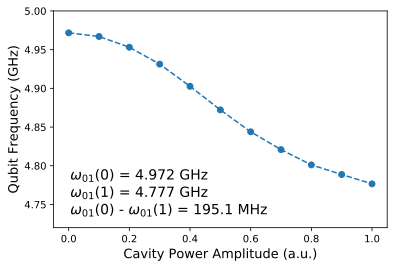

In [36]:
fig, axe = plt.subplots(1, 1, figsize=(6, 4))
    
axe.plot(np.linspace(0, 1, 11), ampqubit_frequencies, '--o') #, np.array(q_freq_error))

plt.ylabel('Qubit Frequency (GHz)', fontsize = 13)
plt.xlabel('Cavity Power Amplitude (a.u.)', fontsize = 13)
plt.ylim([4.72, 5])

plt.text(0.05, 0.24, r'$\omega_{01}$(0) = 4.972 GHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
plt.text(0.05, 0.16, r'$\omega_{01}$(1) = 4.777 GHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
plt.text(0.05, 0.08, r'$\omega_{01}$(0) - $\omega_{01}$(1) = 195.1 MHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)


#plt.xscale('log')

#plt.savefig('acstark.png')
plt.show()

In [27]:
print(ampqubit_frequencies[0])
print(ampqubit_frequencies[-1])
print((ampqubit_frequencies[0] - ampqubit_frequencies[-1])*1e3)


4.971734746901781
4.776636684657495
195.09806224428593


## Subpart Add in the AC stark shift

In [45]:
frequency_shifts = [-1*(ampqubit_frequencies[0] - freq) for freq in ampqubit_frequencies]
#number_of_photons = [ac_stark_map[shift] for shift in frequency_shifts]

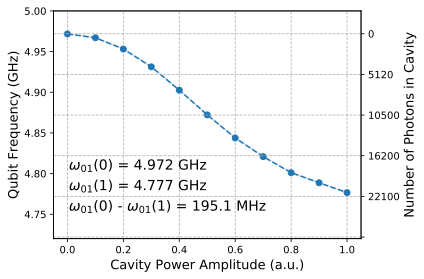

In [280]:
fig, axe = plt.subplots(1, 1, figsize=(6, 4))
    
axe.plot(np.linspace(0, 1, 11), ampqubit_frequencies, '--o') #, np.array(q_freq_error))

plt.ylabel('Qubit Frequency (GHz)', fontsize = 13)
plt.xlabel('Cavity Power Amplitude (a.u.)', fontsize = 13)
plt.ylim([4.72, 5])

yposition = 0.14
difference = 0.09

plt.text(0.05, yposition + 2*difference, r'$\omega_{01}$(0) = 4.972 GHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
plt.text(0.05, yposition + difference, r'$\omega_{01}$(1) = 4.777 GHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
plt.text(0.05, yposition , r'$\omega_{01}$(0) - $\omega_{01}$(1) = 195.1 MHz', 
         horizontalalignment='left', verticalalignment='center', transform = axe.transAxes, fontsize = 14)
ax2 = axe.twinx()
ax2.plot(np.linspace(0, 1, 11), frequency_shifts, alpha = 0.2)
ax2.set_ylim([4.72 - 4.972  , 5-4.972])
ax2.set_yticklabels([None, None ,r'22.1$\times 10^3$', r'16.2$\times 10^3$', r'10.5$\times 10^3$', r'5.1$\times 10^3$', 0])
ax2.set_yticklabels([None, None ,r'22100', '16200', '10500', '5120', 0])

ax2.set_ylabel('Number of Photons in Cavity', fontsize = 13)
#ax2.yaxis.grid(True)#, which = 'both', axis = 'both')
ax2.yaxis.grid(True, linestyle = '--')#, which = 'both', axis = 'both')
axe.xaxis.grid(True, linestyle = '--')#, which = 'both', axis = 'both')

#plt.xscale('log')
plt.tight_layout()

plt.savefig('acstark.png')
plt.show()

# End section

# Start Section
## Plotting numbers

In [110]:
testing = [(4, 'abc', 121),(8, 'abc', 231),(1, 'abc', 148), (2, 'abc',221)]

testing = sorted(testing)

testing = testing[1:]
testing

[(2, 'abc', 221), (4, 'abc', 121), (8, 'abc', 231)]

In [163]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def statistics(list_of_IQdata, xmean_list, ymean_list, sigma_list):
    circle0 = []
    circle1 = []
    circle2 = []
    outliers = []
    
    for IQdata in list_of_IQdata:
        c0, c1, c2, out = sorting_data(IQdata, xmean_list, ymean_list, sigma_list, False)
        circle0.append(c0)
        circle1.append(c1)
        circle2.append(c2)
        outliers.append(out)
        
    print('Circle 0: ', circle0)
    print('Circle 1: ', circle1)
    print('Circle 2: ', circle2)
    print('Outliers: ', outliers)
        
    return(((np.mean(circle0), np.std(circle0)), (np.mean(circle1), np.std(circle1)), 
           (np.mean(circle2), np.std(circle2)), (np.mean(outliers), np.std(outliers))))

def statistics_topx(list_of_IQdata, xmean_list, ymean_list, sigma_list, maximum_number):
    alldata_tuples = []
    
  
    c0, c1, c2, out = sorting_data(list_of_IQdata[0], xmean_list, ymean_list, sigma_list, False)
    
    alldata_tuples.append((out, c0, c1, c2))
    
    for IQdata in list_of_IQdata[1:]:
        c0, c1, c2, out = sorting_data(IQdata, xmean_list, ymean_list, sigma_list, False)
        if out > alldata_tuples[0][0]:
            if len(alldata_tuples) >= maximum_number:
                alldata_tuples = alldata_tuples[1:]
                alldata_tuples.append((out, c0, c1, c2))
            else:
                alldata_tuples.append((out, c0, c1, c2))
        elif len(alldata_tuples) < maximum_number:
            alldata_tuples.append((out, c0, c1, c2))

        
        alldata_tuples = sorted(alldata_tuples)
                
    circle0 = []
    circle1 = []
    circle2 = []
    outliers = []  
    
    for tuples in alldata_tuples:
        out, c0, c1, c2 = tuples
        circle0.append(c0)
        circle1.append(c1)
        circle2.append(c2)
        outliers.append(out)
    
    print('Circle 0: ', circle0)
    print('Circle 1: ', circle1)
    print('Circle 2: ', circle2)
    print('Outliers: ', outliers)
        
    return(((np.mean(circle0), np.std(circle0)), (np.mean(circle1), np.std(circle1)), 
           (np.mean(circle2), np.std(circle2)), (np.mean(outliers), np.std(outliers))))

def IQ_data_generation(job_id):
    job = backend.retrieve_job(job_id)
    IQ_data = get_job_data(job, average=False)
    return (IQ_data)


def sorting_data(IQ_data, xmean_list, ymean_list, sigma_list, plotting = False, xlimits = False, ylimits = False, 
                 savefigure = None, number_points = 1000):
    xmean0, xmean1, xmean2 = xmean_list
    ymean0, ymean1, ymean2 = ymean_list
    sigma0, sigma1, sigma2 = sigma_list
    
    circle0 = 0
    circle1 = 0
    circle2 = 0
    outliers = 0
    
    for imaginary, real in zip(np.imag(IQ_data)[0], np.real(IQ_data)[0]):
        point = (real, imaginary)
        c0_check = check_point(real, imaginary, xmean0, ymean0, sigma0)
        c1_check = check_point(real, imaginary, xmean1, ymean1, sigma1)
        c2_check = check_point(real, imaginary, xmean2, ymean2, sigma2)
        
        if c0_check == 0 and c1_check == 0 and c2_check == 0:
            outliers += 1
        
        circle0 += c0_check
        circle1 += c1_check
        circle2 += c2_check
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.ylabel('I [a.u.]', fontsize=15)
        plt.xlabel('Q [a.u.]', fontsize=15)
        c1 = plt.Circle( (xmean0, ymean0), sigma0 , fill = False ,linewidth = 2, color = 'blue', label = r'$\left|0\right\rangle$')
        c2 = plt.Circle( (xmean1, ymean1), sigma1 , fill = False, linewidth = 2,color = 'red' , label = r'$\left|1\right\rangle$')
        c3 = plt.Circle( (xmean2, ymean2), sigma2 , fill = False, linewidth = 2,color = 'green' , label = r'$\left|2\right\rangle$')
        ax.scatter(np.real(IQ_data[0][:number_points]), np.imag(IQ_data[0][:number_points]), 
                    s=5, cmap='viridis', c='black', alpha=0.6)
        ax.add_patch(c1)
        ax.add_patch(c2)
        ax.add_patch(c3)
        if xlimits:
            plt.xlim(xlimits)
            plt.ylim(ylimits)
        plt.legend(fontsize = 12)
        if savefigure != None:
            plt.savefig(savefigure)

        
    return(circle0, circle1, circle2, outliers)

                
def check_point(x, y, xmean, ymean, sigma):
    
    distance = np.sqrt((xmean - x)**2 + (ymean -y)**2)
    if distance < sigma:
        return (1)
    return(0)

In [240]:
#the calibration data for what IQ values correspond with what qubit state

xmean0 =  18.437770027991043
ymean0 =  -7.71065323833344
xmean1 =  20.08992248758272
ymean1 =  -2.08927400123545
xmean2 =  25.01040538467945
ymean2 =  2.925205713535813
sigma0 = 1.6984978491971718
sigma1 =  1.779054280581652
sigma2 = 1.9046932400961554

xmean_list = [xmean0, xmean1, xmean2]
ymean_list = [ymean0, ymean1, ymean2]

sigma_off = 3
sigma_list = [sigma0*sigma_off, sigma1*sigma_off, sigma2*sigma_off]

In [136]:
#All of these are run with 10 us cavitydrive, 20 cavity ringdown

#Everything here is done with normal backend measurement schedule
jobid_c10_r20_amp0 = ['6095e4117ccc8b618d280002', '6095f3a2eef9e19d7e18b2fd',
 '6095f3a4ceae0758b8d50e8a',
 '6095f3a5ceae07ce8bd50e8b',
 '6095f3a73ce885136b3ff289',
 '6095f3a83ce885b9443ff28a',
 '6095f3f8aa269ef29c02db1b',
 '6095f3f9e742b5583f4ec892',
 '6095f3fba4885e23cc94f969',
 '6095f3fd54112310fa3f3775',
 '6095f3fe7ccc8b151a2800bf']

jobid_c10_r20_amp005 = ['6095e9c954112391743f36f6',
 '6095e9ca3ce88552be3ff20f',
 '6095e9cb3ce885caca3ff211',
 '6095e9ccceae074b30d50e12',
 '6095e9ceeef9e1784818b28b',
 '6095ea246cc828d5782db0b1',
 '6095ea25e742b5a6404ec819',
 '6095ea283ce885b0763ff217',
 '6095ea296cc82844dc2db0b3',
 '6095ea7ceef9e19c5718b290',
 '6095ea7e3ce8855bd63ff21b',
 '6095ea7fceae07fa94d50e1a',
 '6095ea813ce88584e03ff21d',
 '6095ea83c3a1cdb275270c07']

# # amplitude 0.1 only 2 of these. expected to be low so only did 2
jobid_c10_r20_amp01 = ['6094bccca4885e79ec94ee3f', '6094bccee742b5dc604ebd95', '6095e3e7a4885e021394f8bd',
 '6095e3e8c3a1cd5b34270bba',
 '6095e3e96cc8285d312db060',
 '6095e3ea6cc8285b2c2db061', '6096d01fc3a1cd5abe2714e8',
 '6096d021eef9e1d49218bb81',
 '6096d0223ce885cb983ffb6c',
 '6096d023a4885e41e395018d',
 '6096d025aa269e943f02e375', '6096dfefa4885e8d06950212',
 '6096dff0ceae07d7c4d5179d',
 '6096dff17ccc8be19d280994',
 '6096dff3a4885e48dc950213',
 '6096dff4e742b541b84ed16c',  '6095f4697ccc8bcfd92800c3',
 '6095f46aaa269e451802db20',
 '6095f46caa269ec25702db21',
 '6095f46deef9e1247d18b306',
 '6095f46ec3a1cd46dd270c79']

jobid_c10_r20_amp015 = ['6095e7f87ccc8b5dbc28002d',
 '6095e7f93ce885c4653ff1fd',
 '6095e7faeef9e1294f18b272',
 '6095e7fbceae0785b2d50df8',
 '6095e7fc7ccc8b614728002e',
 '6095e85cceae079cf8d50dfb',
 '6095e85ec3a1cd54bd270bf0',
 '6095e85f3ce88597303ff202',
 '6095e860ceae073112d50dfc',
 '6095e861aa269e757902da9d',
 '6095e8be6cc828a0a92db09a',
 '6095e8bf7ccc8ba86f280034',
 '6095e8c0aa269e23c902daa1',
 '6095e8c1c3a1cd38e9270bf4',
 '6095e8c27ccc8bc3a2280035']

# # amplitude 0.2
jobid_c10_r20_amp02 = ['6095479ec3a1cd1330270643',
 '6095479feef9e198a518ac84', '6095e36aeef9e1031418b241',
 '6095e36beef9e1266718b242',
 '6095e36c5411239f593f36aa',
 '6095e36d3ce88569ae3ff1c9',
 '6095e36eeef9e1708918b243', '6095e6b13ce8854bb83ff1eb',
 '6095e6b3c3a1cd2959270bd9',
 '6095e6b4eef9e1574318b263',
 '6095e6b6aa269e412a02da8d',
 '6095e6b7541123b6023f36d0',
 '6095e7056cc828fc782db086',
 '6095e7063ce8852f1e3ff1f0',
 '6095e707ceae07246ad50de8',
 '6095e7087ccc8b93f6280024',
 '6095e70954112339913f36d7',
 '6095e7676cc82827bc2db08a',
 '6095e768eef9e1257618b269',
 '6095e76aceae07a489d50ded',
 '6095e76bceae070f91d50dee',
 '6095e76be742b52ab94ec7ff']

jobid_c10_r20_amp025 = ['6095eb267ccc8b4080280054',
 '6095eb28c3a1cd5dea270c10',
 '6095eb2aceae0722a1d50e23',
 '6095eb2be742b5d9194ec824',
 '6095eb2cceae07bc55d50e24',
 '6095ec07eef9e170a218b2a4',
 '6095ec09ceae07c37bd50e2c',
 '6095ec0a7ccc8bb8ad28005e',
 '6095ec0ce742b5a0674ec832',
 '6095ec0ec3a1cde93d270c18',
 '6095ec89eef9e1b7eb18b2ac',
 '6095ec8b5411233a413f3712',
 '6095ec8c6cc8282e5d2db0c8',
 '6095ec8eeef9e1889818b2ad',
 '6095ec8fceae0765d6d50e34']

# # amplitude 0.3 has 3 of these
jobid_c10_r20_amp03 = ['6094bccfa4885e52f394ee40',
 '6094bcd0e742b5bc594ebd96',
 '6094bcd17ccc8b59d627f596', '6095cc0de742b5bd734ec6eb',
 '6095cc29eef9e1377418b143',
 '6095cc2aaa269e5b2402d96e',
 '6095cc2c6cc82813632daf7a',
 '6095cc2dceae0760a4d50cce',
 '6095d559eef9e1800e18b1aa',
 '6095d55b5411232d843f360e',
 '6095d55cceae0784f3d50d35',
 '6095d55e3ce8852eb63ff12f',
 '6095d55f7ccc8b406e27ff5f',
 '6095d5f67ccc8b7c5b27ff68',
 '6095d5f76cc82800c02dafce',
 '6095d5f8ceae077a2ad50d3a',
 '6095d5f9eef9e128fc18b1b9',
 '6095d5fae742b561824ec74d']

# # amplitude 3.5
jobid_c10_r20_amp035 = ['609547a1a4885e03e294f314',
 '609547a2eef9e13e5018ac85',
 '609547a47ccc8b621c27fa6f', '6095ed3bceae072165d50e3a',
 '6095ed3c54112380093f371d',
 '6095ed3f6cc828b20f2db0cf',
 '6095ed41c3a1cd97c8270c24',
 '6095ed42a4885ef4f794f91f',
 '6095edbc3ce88548a93ff244',
 '6095edbd54112322903f3722',
 '6095edbeceae07c9d5d50e41',
 '6095edc0eef9e1c21d18b2ba',
 '6095edc13ce8852d693ff245']

# 0.4 
jobid_c10_r20_amp04 = ['60953d00e742b5e2c44ec1e1',
 '60953d02541123d82c3f30b3',
 '60953d03a4885e131394f295',
 '60953d04c3a1cd57eb2705ce',
 '60953d066cc828294f2daa47', '609555eeceae0737fcd508a5', '609555f3ceae07701bd508a8', '6095abf1c3a1cd45d82709b0',
 '6095abf2ceae0720c2d50ba1',
 '6095abf354112305093f348d',
 '6095abf45411235f1b3f348f',
 '6095abf554112328e23f3490', '6095acbdc3a1cd5ecf2709b7',
 '6095acbe541123376a3f3498',
 '6095acbfeef9e185b518b00d',
 '6095acc06cc8282b142dae36',
 '6095acc1eef9e1c24118b00e',
 '6095ad95c3a1cd47862709bb',
 '6095ad97eef9e1fbe618b015',
 '6095ad98a4885e511b94f6ae',
 '6095ad99c3a1cdaf8e2709bd',
 '6095ad9a3ce885b9163fefa1',
 '6095aeade742b517e54ec5d9',
 '6095aeaec3a1cd65502709c4',
 '6095aeafeef9e1634818b023',
 '6095aeb0c3a1cd26142709c5',
 '6095aeb1eef9e1627218b024']

# 0.45 
jobid_c10_r20_amp045 = ['609555f0a4885e281b94f390',
 '609555f1a4885e37d194f391',
 '609555f2ceae07e84fd508a7', '60972f155411237a8a3f430e',
 '60972f18a4885e6a9a9504b6',
 '60972f1a7ccc8bab22280c36',
 '60972f1bc3a1cd60ae27181c',
 '60972f1daa269e401d02e6a0',
 '60973247ceae0776c9d51a5a',
 '609732497ccc8b48f1280c4b',
 '6097324aaa269e483402e6b9',
 '6097324ce742b508c54ed43c',
 '6097324d6cc82818932dbcc7']

# # 0.5:
jobid_c10_r20_amp05 = ['6095401eceae077958d507ec',
 '6095401fc3a1cd8d1a2705f0',
 '60954020c3a1cdf34d2705f1',
 '60954021a4885e3a2394f2c2',
 '60954023ceae07570bd507ed', '6095b0ee54112325fe3f34bc',
 '6095b0efeef9e1173018b036',
 '6095b0f07ccc8bde7427fe03',
 '6095b0f13ce8854fad3fefb8',
 '6095b0f3aa269e33f302d86d',
 '6095b210aa269e5dcc02d877',
 '6095b211e742b52fd34ec5f3',
 '6095b212eef9e1463a18b042',
 '6095b213e742b520d14ec5f4',
 '6095b214aa269ede4602d878',
 '6095b35eeef9e1b06b18b04d',
 '6095b35f541123e05e3f34cf',
 '6095b360e742b579014ec601',
 '6095b361eef9e1a8e218b04e',
 '6095b362e742b5a1904ec602',
 '6095b4986cc828d2692dae7b',
 '6095b499c3a1cd17872709f8',
 '6095b49a6cc828764a2dae7c',
 '6095b49b3ce88541a73fefd5',
 '6095b49c7ccc8b778b27fe1d']

jobid_c10_r20_amp055 = ['6095ee87e742b563074ec84e',
 '6095ee89541123671b3f372e',
 '6095ee8ae742b556404ec84f',
 '6095ee8caa269e5a3f02dae4',
 '6095ee913ce885efa43ff252',
 '6095ef0b5411234e823f3739',
 '6095ef0c7ccc8b35c4280086',
 '6095ef0ea4885e215394f92e',
 '6095ef0faa269e84e102dae8',
 '6095ef11eef9e1166318b2c6',
 '6095ef9be742b505ed4ec85e',
 '6095ef9cceae072150d50e56',
 '6095ef9ec3a1cdcac2270c3b',
 '6095ef9fa4885e5ff694f935',
 '6095efa15411235d903f3740']

# amplitude 0.6 with 5 copies
jobid_c10_r20_amp06 = ['6094cea7eef9e1799d18a830',
 '6094cea87ccc8b8a8227f60a',
 '6094cea97ccc8b0fdf27f60b',
 '6094ceaaeef9e1086718a831',
 '6094ceabc3a1cdb6152701e9',  '6095b99ac3a1cd67ee270a24',
 '6095b99beef9e12faf18b08c',
 '6095b99cceae0726e1d50c19',
 '6095b99d6cc8284dfa2daea9',
 '6095b99e6cc828450c2daeaa',
 '6095ba6fe742b554ad4ec643',
 '6095ba707ccc8bc46d27fe52',
 '6095ba716cc82821ae2daeb4',
 '6095ba72541123003b3f3505',
 '6095ba7354112365f03f3506',
 '6095bb613ce885b2c43ff01b',
 '6095bb63eef9e16e9018b09a',
 '6095bb647ccc8bc9a527fe5e',
 '6095bb657ccc8be54527fe5f',
 '6095bb68ceae076fe5d50c28']

jobid_c10_r20_amp065 = ['60973e4d6cc828830b2dbd30',
 '60973e4feef9e1685318bf22',
 '60973e50ceae077173d51ac9',
 '60973e51c3a1cd729327189b',
 '60973e523ce8854fe63fff2d',
 '60973eb4c3a1cd76a22718a0',
 '60973eb5ceae077465d51acf',
 '60973eb6ceae074cf8d51ad0',
 '60973eb7a4885e9287950535',
 '60973eb8e742b5bb1a4ed4a6',
 '60973f1cceae07730ed51ad5',
 '60973f1d6cc8284f372dbd37',
 '60973f1e7ccc8b212e280cbf',
 '60973f1faa269e90cd02e73a',
 '60973f2054112329eb3f4387']

# amplitude 0.7 with 5 copies
jobid_c10_r20_amp07 = ['6095456cc3a1cd310c27062b',
 '6095456d7ccc8b5ed027fa56',
 '6095456faa269ee40b02d4ca',
 '609545707ccc8b44b627fa57',
 '609545727ccc8bf4ad27fa58', '6095bdbfe742b5fc3f4ec667',
 '6095bdbfc3a1cd9056270a46',
 '6095bdc03ce885ca5c3ff033',
 '6095bdc13ce885ae053ff034',
 '6095bdc3ceae0762d4d50c43',
 '6095be4beef9e14ce018b0b4',
 '6095be4ca4885e583394f743',
 '6095be4dc3a1cd60a3270a4d',
 '6095be4ec3a1cd651c270a4e',
 '6095be50a4885e7fd394f744',
 '6095beb7aa269e64a302d8e4',
 '6095beb8c3a1cd7cd5270a55',
 '6095bebaceae072c87d50c4a',
 '6095bebca4885ed47494f74a',
 '6095bebde742b562714ec670']

jobid_c10_r20_amp075 = ['60973c84a4885e68d595051f',
 '60973c85aa269eebb302e71d',
 '60973c86e742b571a64ed48c',
 '60973c883ce88509d73fff19',
 '60973c893ce8857ed63fff1a',
 '60973cdda4885edda6950522',
 '60973cdeaa269e4ea102e723',
 '60973cdfe742b542f54ed48e',
 '60973ce0e742b5513b4ed48f',
 '60973ce16cc82888ed2dbd1e',
 '60973d466cc828e2bf2dbd24',
 '60973d4754112336a13f4377',
 '60973d48aa269e995202e727',
 '60973d49e742b55c174ed495',
 '60973d4aaa269e1bfc02e728']

# amplitude 08 5 copies = 
jobid_c10_r20_amp08 = ['60952d91e742b547e24ec14e',
 '60952d947ccc8b5e7427f972',
 '60952d955411230d603f301c',
 '60952d96eef9e1abdc18ab7d',
 '60952d98aa269efcb202d3c5', '6095c16dceae071b3bd50c62',
 '6095c16ec3a1cd07f0270a73',
 '6095c1703ce8850f733ff05b',
 '6095c171aa269e09d802d8fd',
 '6095c173aa269e840802d8fe',
 '6095c257eef9e133df18b0db',
 '6095c2596cc828b55c2daf08',
 '6095c25aaa269e2afe02d907',
 '6095c25c541123c7c53f354b',
 '6095c25deef9e128b718b0dc',
 '6095c2c26cc8283a732daf0b',
 '6095c2c3a4885eecd394f774',
 '6095c2c4aa269e747f02d90d',
 '6095c2c67ccc8b7f0f27fea6',
 '6095c2c7c3a1cd618d270a7d']

jobid_c10_r20_amp085 = ['60973830ceae07efbfd51a89',
 '60973831e742b5132c4ed468',
 '609738323ce8853d8c3ffef0',
 '60973834aa269e128402e6ea',
 '609738356cc82805592dbcf1',
 '60973a86ceae077afad51a9d',
 '60973a873ce88581b53fff04',
 '60973a88aa269edd0902e702',
 '60973a89eef9e1313618befb',
 '60973a8aaa269e34b902e703',
 '60973af0c3a1cd499c271879',
 '60973af1a4885e4067950509',
 '60973af3ceae07096ad51aa4',
 '60973af4c3a1cde32227187a',
 '60973af55411237b613f4360']

# amplitude 09 5 copies = 
jobid_c10_r20_amp09 = ['60954dbe6cc8286af52daaf0',
 '60954dbf7ccc8b72fb27faa0',
 '60954dc17ccc8ba2e927faa1',
 '60954dc2541123e3da3f3165',
 '60954dc37ccc8b07df27faa3', '6095c504541123399e3f3563',
 '6095c505e742b501c44ec6a7',
 '6095c5077ccc8bdaba27feb7',
 '6095c508aa269e921002d925',
 '6095c509aa269e66e602d926',
 '6095c5de3ce885a59d3ff089',
 '6095c5e0eef9e14cc018b0fc',
 '6095c5e2541123fcde3f356e',
 '6095c5e33ce8854d3d3ff08a',
 '6095c5e56cc828586b2daf2a',
 '6095c6d36cc82814902daf33',
 '6095c6d5ceae077296d50c98',
 '6095c6d6a4885e649394f793',
 '6095c6d8a4885e18fa94f794',
 '6095c6da541123f5f03f3576']

jobid_c10_r20_amp095 = ['6097348d7ccc8b2731280c5f',
 '6097348f54112327df3f4335',
 '609734907ccc8b68f1280c60',
 '60973491eef9e1968e18bec8',
 '60973492e742b50e624ed450',
 '60973658a4885e08df9504e5',
 '60973659aa269e97d002e6d9',
 '6097365a3ce88538753ffee2',
 '60973661eef9e1831e18bed8',
 '609736633ce88585713ffee3',
 '609736ebaa269e447c02e6df',
 '609736ecaa269e1a2f02e6e0',
 '609736ede742b512524ed45f',
 '609736ee6cc828ea462dbce9',
 '609736f06cc828dde02dbcea']

# Amplitude 1, 
jobid_c10_r20_amp1 = ['6094b00cc3a1cd0af8270119',
 '6094b00eceae075ac2d5031a',
 '6094b00feef9e10f9518a76c',
 '6094b011c3a1cd3e7c27011a',
 '6094b0127ccc8b950027f541', '6095cc0de742b5bd734ec6eb',
 '6095cc29eef9e1377418b143',
 '6095cc2aaa269e5b2402d96e',
 '6095cc2c6cc82813632daf7a',
 '6095cc2dceae0760a4d50cce', '6095cc0de742b5bd734ec6eb',
 '6095cc29eef9e1377418b143',
 '6095cc2aaa269e5b2402d96e',
 '6095cc2c6cc82813632daf7a',
 '6095cc2dceae0760a4d50cce',
 '6095d559eef9e1800e18b1aa',
 '6095d55b5411232d843f360e',
 '6095d55cceae0784f3d50d35',
 '6095d55e3ce8852eb63ff12f',
 '6095d55f7ccc8b406e27ff5f',
 '6095d5f67ccc8b7c5b27ff68',
 '6095d5f76cc82800c02dafce',
 '6095d5f8ceae077a2ad50d3a',
 '6095d5f9eef9e128fc18b1b9',
 '6095d5fae742b561824ec74d']


In [137]:
all_job_list_names = [jobid_c10_r20_amp0, jobid_c10_r20_amp005, jobid_c10_r20_amp01, jobid_c10_r20_amp015, 
                      jobid_c10_r20_amp02, jobid_c10_r20_amp025, jobid_c10_r20_amp03, jobid_c10_r20_amp035, 
                     jobid_c10_r20_amp04, jobid_c10_r20_amp045, jobid_c10_r20_amp05, jobid_c10_r20_amp055, 
                     jobid_c10_r20_amp06, jobid_c10_r20_amp065, jobid_c10_r20_amp07, jobid_c10_r20_amp075, 
                     jobid_c10_r20_amp08, jobid_c10_r20_amp085, jobid_c10_r20_amp09, jobid_c10_r20_amp095, 
                     jobid_c10_r20_amp1]

In [138]:
all_IQ_arrays = []
for job_list in all_job_list_names:
    all_IQ_arrays.append([IQ_data_generation(job_id) for job_id in job_list])

In [139]:
amplitude_drives = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 
                    0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

In [140]:
list_of_all_statistics = []
for IQarray in all_IQ_arrays:
    list_of_all_statistics.append(statistics(IQarray, xmean_list, ymean_list, sigma_list))

Circle 0:  [8118, 8129, 8130, 8114, 8105, 8105, 8107, 8129, 8107, 8133, 8135]
Circle 1:  [3270, 2713, 2622, 2564, 2577, 2420, 2505, 2640, 2638, 2515, 2608]
Circle 2:  [1, 7, 10, 9, 16, 12, 11, 5, 11, 0, 1]
Outliers:  [34, 34, 41, 47, 51, 52, 44, 43, 48, 47, 41]
Circle 0:  [8127, 8122, 8113, 8121, 8140, 8130, 8106, 8123, 8134, 8126, 8101, 8131, 8122, 8095]
Circle 1:  [3072, 3006, 3065, 3204, 3005, 3177, 3123, 3172, 3166, 3459, 3571, 3562, 3769, 3770]
Circle 2:  [3, 5, 1, 1, 4, 2, 4, 3, 4, 5, 6, 2, 2, 7]
Outliers:  [33, 43, 42, 39, 27, 31, 50, 33, 22, 37, 44, 22, 28, 27]
Circle 0:  [8120, 8150, 8118, 8120, 8134, 8109, 8127, 8137, 8136, 8141, 8144, 8113, 8094, 8119, 8121, 8133, 8003, 7984, 7987, 8008, 8021]
Circle 1:  [2761, 2715, 3424, 3315, 3300, 3186, 2644, 2713, 2840, 2553, 2759, 3067, 3079, 2769, 2632, 2392, 2625, 2702, 2846, 2427, 2578]
Circle 2:  [3, 0, 3, 5, 0, 1, 3, 2, 3, 2, 0, 8, 11, 8, 4, 2, 113, 127, 126, 97, 103]
Outliers:  [45, 30, 28, 25, 32, 39, 32, 40, 42, 33, 34, 38, 44,

In [255]:
circle0_vals = []
circle1_vals = []
circle2_vals = []
outliers_vals = []

circle0_valss = []
circle1_valss = []
circle2_valss = []
outliers_valss = []

for all_vals in list_of_all_statistics:
    #print(all_vals)
    (c0, c0s), (c1, c1s), (c2, c2s), (out, outs) = all_vals
    circle0_vals.append(c0 / (1024.*8))
    circle1_vals.append(c1/ (1024.*8))
    circle2_vals.append(c2/ (1024.*8))
    outliers_vals.append(out/ (1024.*8))
    
    circle0_valss.append(c0s / (1024.*8))
    circle1_valss.append(c1s/ (1024.*8))
    circle2_valss.append(c2s/ (1024.*8))
    outliers_valss.append(outs/ (1024.*8))

((8119.272727272727, 11.592245912214603), (2642.909090909091, 212.23548437159673), (7.545454545454546, 4.979295977319691), (43.81818181818182, 5.765385452984701))
((8120.785714285715, 12.370348022755126), (3294.3571428571427, 264.3678733299105), (3.5, 1.7627089541790095), (34.142857142857146, 8.313991158257979))
((8096.142857142857, 55.202903403876206), (2825.095238095238, 286.26077101996236), (29.571428571428573, 47.19117293224537), (40.333333333333336, 8.903361234378917))
((8072.2, 37.459667199091164), (3125.2, 239.38760758791727), (15.333333333333334, 11.358794928258114), (76.06666666666666, 29.1878208999728))
((8076.454545454545, 69.6365416565491), (3264.318181818182, 200.53845388753575), (38.0, 51.13351507217515), (38.90909090909091, 9.944889463753784))
((8115.4, 9.039174003561756), (3602.266666666667, 250.4091230144958), (2.1333333333333333, 1.4544949486180951), (33.4, 3.2207659544483103))
((7919.888888888889, 185.18935921221848), (3338.5555555555557, 329.11180508592145), (40.611

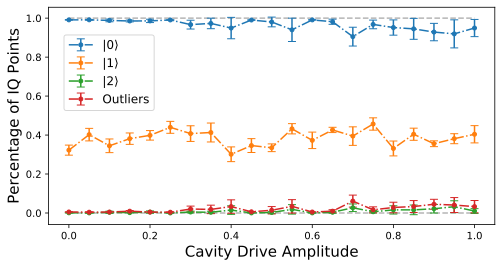

In [269]:
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('Cavity Drive Amplitude', fontsize=15)
plt.ylabel('Percentage of IQ Points', fontsize=15)

plt.hlines(1, 0, 1, alpha = 0.3,linestyle = '--')
plt.hlines(0, 0, 1, alpha = 0.3,linestyle = '--')


plt.errorbar(amplitude_drives, circle0_vals, yerr = circle0_valss, linestyle = '-.', markersize = 4, capsize = 4, fmt = 'o', label = r'$\left|0\right\rangle$')
plt.errorbar(amplitude_drives, circle1_vals, circle1_valss, linestyle =  '-.', markersize = 4, capsize = 4, fmt = 'o', label = r'$\left|1\right\rangle$')
plt.errorbar(amplitude_drives, circle2_vals, circle2_valss, linestyle = '-.', markersize = 4, capsize = 4, fmt = 'o', label = r'$\left|2\right\rangle$')
plt.errorbar(amplitude_drives, outliers_vals, outliers_valss, linestyle = '-.',markersize = 4, capsize = 4, fmt = 'o',  label = 'Outliers')



# plt.xlim(xlimits)
# plt.ylim(ylimits)
plt.legend(fontsize = 12, loc='best', bbox_to_anchor=(0.05, 0.4, 0.2, 0.5))
plt.savefig('points_per_amplitude.png')

next because of the inconsistency issues I wanted to see if the plot results would look significantly different if I only plotted the 10 jobs with the largest number of outliers. The plots did not look that differently so I did not comment on them in the project

In [152]:
list_of_all_statistics_top10 = []
for IQarray in all_IQ_arrays:
    list_of_all_statistics_top10.append(statistics_topx(IQarray, xmean_list, ymean_list, sigma_list, 10))

Circle 0:  [8129, 8130, 8135, 8129, 8107, 8114, 8133, 8107, 8105, 8105]
Circle 1:  [2713, 2622, 2608, 2640, 2505, 2564, 2515, 2638, 2577, 2420]
Circle 2:  [7, 10, 1, 5, 11, 9, 0, 11, 16, 12]
Outliers:  [34, 41, 41, 43, 44, 47, 47, 48, 51, 52]
Circle 0:  [8122, 8130, 8123, 8127, 8126, 8121, 8113, 8122, 8101, 8106]
Circle 1:  [3769, 3177, 3172, 3072, 3459, 3204, 3065, 3006, 3571, 3123]
Circle 2:  [2, 2, 3, 3, 5, 1, 1, 5, 6, 4]
Outliers:  [28, 31, 33, 33, 37, 39, 42, 43, 44, 50]
Circle 0:  [8119, 8136, 8094, 8133, 8120, 8121, 7984, 8003, 7987, 8008]
Circle 1:  [2769, 2840, 3079, 2392, 2761, 2632, 2702, 2625, 2846, 2427]
Circle 2:  [8, 3, 11, 2, 3, 4, 127, 113, 126, 97]
Outliers:  [41, 42, 44, 44, 45, 45, 49, 49, 57, 61]
Circle 0:  [8071, 8070, 8067, 8060, 8048, 8039, 8041, 8039, 8007, 8040]
Circle 1:  [2931, 3001, 2853, 3081, 3046, 3079, 2729, 3053, 3063, 3004]
Circle 2:  [18, 20, 14, 15, 28, 26, 23, 19, 42, 13]
Outliers:  [76, 78, 83, 88, 90, 92, 100, 103, 117, 121]
Circle 0:  [8123, 812

In [153]:
circle0_valst10 = []
circle1_valst10 = []
circle2_valst10 = []
outliers_valst10 = []

for all_vals in list_of_all_statistics_top10:
    (c0, c0s), (c1, c1s), (c2, c2s), (out, outs) = all_vals
    circle0_valst10.append(c0 / (1024.*8))
    circle1_valst10.append(c1/ (1024.*8))
    circle2_valst10.append(c2/ (1024.*8))
    outliers_valst10.append(out/ (1024.*8))


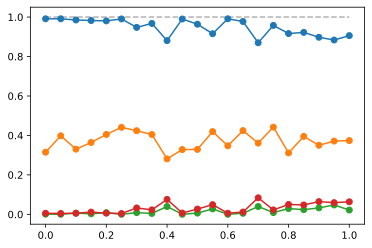

In [154]:
plt.hlines(1, 0, 1, alpha = 0.3,linestyle = '--')

plt.plot(amplitude_drives, circle0_valst10, '-o')
plt.plot(amplitude_drives, circle1_valst10, '-o')
plt.plot(amplitude_drives, circle2_valst10, '-o')
plt.plot(amplitude_drives, outliers_valst10, '-o')

Next, Here are the plots for figure 6 One thing to note is that right now I set number of points to 1000 because matplotlib does not like plotting many points. When actually saving the data I switched that to 8000

In [155]:
IQ01 = [IQ_data_generation(job_id) for job_id in jobid_c10_r20_amp01]

In [156]:
IQ05 = [IQ_data_generation(job_id) for job_id in jobid_c10_r20_amp05]

In [157]:
IQ1 = [IQ_data_generation(job_id) for job_id in jobid_c10_r20_amp1]

(7987, 2846, 126, 57)

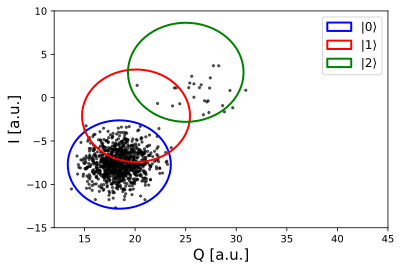

In [164]:
sorting_data(IQ01[-3], xmean_list, ymean_list, sigma_list, True, (12, 45), (-15, 10), None, 1000)

(7709, 2620, 112, 350)

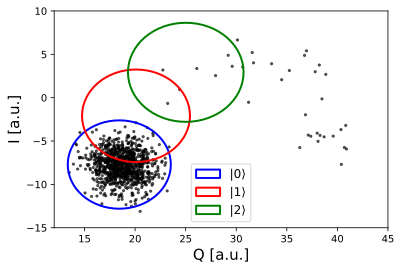

In [165]:
sorting_data(IQ05[10], xmean_list, ymean_list, sigma_list, True, (12, 45), (-15, 10),None, 1000)

(7369, 2727, 205, 576)

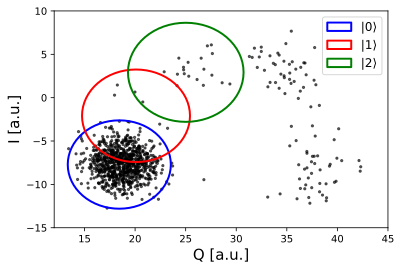

In [166]:
sorting_data(IQ1[2], xmean_list, ymean_list, sigma_list, True, (12, 45), (-15, 10),None, 1000)

# Start Section
## Appendix 

In [185]:
# optimizing measurement differences  using 7us measurmeent time instead

In [189]:
manualmeas_015_7us_amplitude0 = ['6095a5cf6cc828d0692dadf7']

manualmeas_015_7us_amplitude01 = ['6095a5d15411235e9e3f345e']

manualmeas_015_7us_amplitude02 = ['6095a5d26cc8285a5a2dadf8']

manualmeas_015_7us_amplitude03 = ['6095a5d3eef9e1f96118afd4']

manualmeas_015_7us_amplitude04 = ['6095a5d5e742b56cf04ec58f']

manualmeas_015_7us_amplitude05 = ['6095a6376cc8280ca92dadfc']

manualmeas_015_7us_amplitude06 = ['6095a639e742b59bf74ec595']

manualmeas_015_7us_amplitude07 = ['6095a63ba4885eb61a94f66a']

manualmeas_015_7us_amplitude08 = ['6095a63caa269e076302d813']

manualmeas_015_7us_amplitude09 = ['6095a63eceae07ac4bd50b6e']

manualmeas_015_7us_amplitude1 = ['6095a6a3e742b5bc2a4ec599']


In [251]:
xmean0 =  -7.79170173861888
ymean0 =  2.27445142618384
xmean1 =  -8.25353924706304
ymean1 =  -0.17578280181758
xmean2 =  -10.0104020244486
ymean2 =  -2.46038839456437
sigma0 = 1.5643669565904639
sigma1 =  1.7156810163886824
sigma2 = 1.5802242680874432

xmean_list = [xmean0, xmean1, xmean2]
ymean_list = [ymean0, ymean1, ymean2]

sigma_off = 3
sigma_list = [sigma0*sigma_off, sigma1*sigma_off, sigma2*sigma_off]

In [192]:
job_of_interest = backend.retrieve_job(manualmeas_015_7us_amplitude06[0])

In [198]:
IQ_data_manual = IQ_data_generation(manualmeas_015_7us_amplitude1[0])

(7708, 7542, 2993, 223)

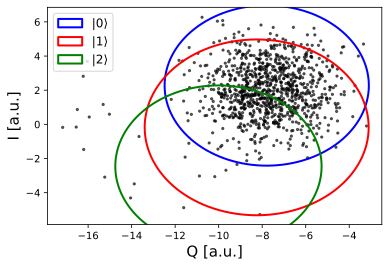

In [252]:
sorting_data(IQ_data_manual, xmean_list, ymean_list, sigma_list, True, number_points=1000)#, (12, 45), (-15, 8), 1000)

In the above plot we see that there are fewer points for amplitude 1 but the circles for 0, 1, 2 significalty overlap so we decided to use our normal measurmeent pulse. 

## Appendix section 7.3 where we look at the IQ value for a 10us ringdown and determine it is not enough time. 

In [234]:
def plotting_noqubit(job, xlims = None, ylims = None, title = 'Cav driving', savename = 'name'):
    IQ_data = get_job_data(job, average=False)
    
    num_0 = 0
    for imaginary, real in zip(np.imag(IQ_data)[0], np.real(IQ_data)[0]):
        if imaginary > 25 or real < -2.5:
            num_0 += 1
    print('Number of points above 18 imag: ', num_0)
    fig = plt.figure(figsize = (5, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(np.real(IQ_data[0][:1000]), np.imag(IQ_data[0][:1000]), 
                    s=5, cmap='viridis', c='black', alpha=1)
   
    if xlims != None:
        plt.xlim(xlims)
    if ylims != None:
        plt.ylim(ylims)
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    

    
    xmean0 =  2.1037953630475803  
    ymean0 =  20.50756465524736  
    xmean1 =  -4.60458534970896  
    ymean1 =  20.50336344113152   
    xmean2 =  -8.592470403361279   
    ymean2 =  23.14550876831744   
    sigma0 = 1.7583446529786049
    sigma1 = 1.7371807139049609
    sigma2 = 2.0010237241665263
    

    c1 = plt.Circle( (xmean0, ymean0), 3*sigma0 , fill = False , color = 'blue', label = r'$\left|0\right\rangle$')

    
    ax.add_patch(c1)
    #ax.add_patch(c2)
    #ax.add_patch(c3)
    plt.legend(fontsize = 13)

    plt.title(title, fontsize=15)
    
    plt.savefig(savename)

In [228]:
# '60944f7bceae075bc9d4ff4f', amplitude 0
#  '60944f7d6cc828757a2da1aa', amplitude 0.2
#  '60944f7f5411236ef53f282c', amplitude 0.6
#  '60944f807ccc8bb91227f14e' amplitude 0.8
# 60944f3c6cc828d6362da1a7 amplitude 1


Number of points above 18 imag:  34


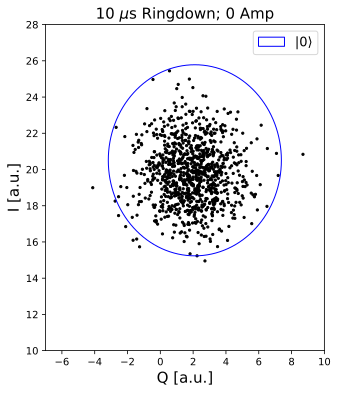

In [235]:
job_of_interest = backend.retrieve_job('60944f7bceae075bc9d4ff4f')
plotting_noqubit(job_of_interest,[-7, 10], [10, 28], "10 $\mu$s Ringdown; 0 Amp", "appring0")

Number of points above 18 imag:  17


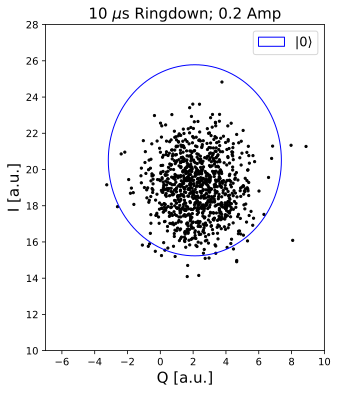

In [236]:
job_of_interest = backend.retrieve_job('60944f7d6cc828757a2da1aa')
plotting_noqubit(job_of_interest, [-7, 10], [10, 28], "10 $\mu$s Ringdown; 0.2 Amp", "appring02")

Number of points above 18 imag:  415


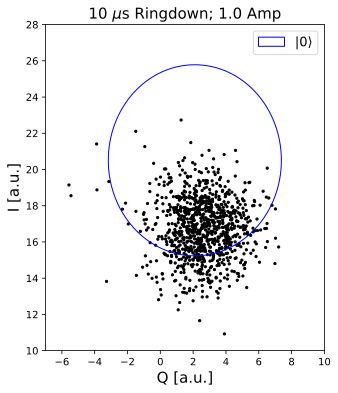

In [237]:
job_of_interest = backend.retrieve_job('60944f3c6cc828d6362da1a7')
plotting_noqubit(job_of_interest, [-7, 10], [10, 28], "10 $\mu$s Ringdown; 1.0 Amp", "appring1")

## Example of inconsistency Appendix section 7.1

In [ ]:
IQ1 = [IQ_data_generation(job_id) for job_id in jobid_c10_r20_amp1]

(6942, 2506, 306, 877)

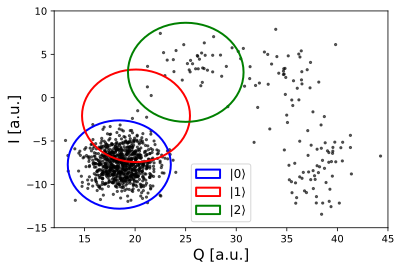

In [249]:
sorting_data(IQ1[0], xmean_list, ymean_list, sigma_list, True, (12, 45), (-15, 10),None, 1000)

(8109, 3351, 3, 38)

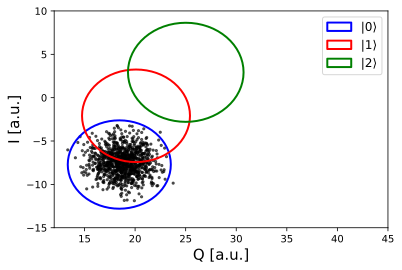

In [248]:
sorting_data(IQ1[5], xmean_list, ymean_list, sigma_list, True, (12, 45), (-15, 10),None, 1000)

# To actually generate the jobs, here is the code:

In [282]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib

from qiskit.tools.monitor import job_monitor


import numpy as np
import matplotlib.pyplot as plt


# do this so that when call backend, will look nice, report properties

%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# check qiskit version
import qiskit
qiskit.__qiskit_version__
# make sure the version is up to date!

ibmqfactory.load_account:WARNING:2021-05-10 16:16:57,313: Credentials are already in use. The existing account in the session will be replaced.


{'qiskit-terra': '0.17.0', 'qiskit-aer': '0.8.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.0', 'qiskit': '0.25.0'}

In [283]:
# basic unit conversion factors and device properties

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
scale_factor = 1e-14 # scale factor to remove factors of 10 from the data

# basic parameters
qubit = 0 # there is only one qubit
dt = backend_config.dt
#defaults
backend_defaults = backend.defaults()

# drive parameters
[[min_drive_freq, max_drive_freq]] = backend_config.qubit_lo_range # range of freqs for qubit drive, 1Ghz around wq
[[min_meas_freq, max_meas_freq]] = backend_config.meas_lo_range # range of freqs for measurement drive

# cavity parameters
cavity_freq = backend_defaults.meas_freq_est[qubit]

# qubit parameters
qubit_props_dict = backend.properties().qubit_property(0)
qubit_freq = qubit_props_dict['frequency'][0]
qubit_T1 = qubit_props_dict['T1'][0]
qubit_T2 = qubit_props_dict['T2'][0]
qubit_anharm = qubit_props_dict['anharmonicity'][0]

print(f"sampling time: {dt / ns : .2f} ns.")
print(f"Max eperiments, max shots: {backend_config.max_experiments}, {backend_config.max_shots}")
print(f"qubit frequency: {qubit_freq / GHz} GHz.")
print(f"qubit decay: {1 /(qubit_T1* MHz)} MHz.")
print(f"qubit dephase: {1 /(qubit_T1* MHz)} MHz.")
print(f"qubit anharmonicity: {qubit_anharm / GHz} GHz.")

print(f"cavity frequency: {cavity_freq / GHz} GHz.")
# qubit_props_dict # other interesting parameters

sampling time:  0.22 ns.
Max eperiments, max shots: 75, 8192
qubit frequency: 4.97186208283383 GHz.
qubit decay: 0.006264871386576632 MHz.
qubit dephase: 0.006264871386576632 MHz.
qubit anharmonicity: -0.3471929314828262 GHz.
cavity frequency: 6.993370669 GHz.


In [284]:
# get default schedules and measurement map


# qiskit groups qubits into measurement groups which all need to be measured simultaneously
# Find out which group of qubits need to be acquired with this qubit
# here its just itself, since there is only 1 qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
print(f"Qubit in measurement group {meas_map_idx}")
qubit_meas_group = backend_config.meas_map[meas_map_idx]

#default instructions
inst_sched_map = backend_defaults.instruction_schedule_map #default pulses so dont have to construct by hand

# available channels - need to specify channels to which pulses are applied
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit) # note that each acquisiton pulse needs to have a simultaneous measurement pulse


# these are schedules, so already have channels associated with them, and can just be added to other schedules
pi_pulse = inst_sched_map.get('x', qubit_meas_group) #pi pulse

default_measure = inst_sched_map.get('measure', qubit_meas_group) #drive on measurement cavity + aquisiton window open

# meas_square = inst_sched_map.get('MEAS', qubits=qubit_meas_group) #constant drive on measure pulse, 3.5 us duration, no acquisition


Qubit in measurement group 0


In [285]:
#This code is used to make a manual measurmeent pulse that was tested for an effect on cavity IQ values

meas_time_us = 7
meas_amp = 0.15
meas_sigma_us = 0.01
meas_risefall_us = 0.02

meas_time = get_closest_multiple_of_16(meas_time_us * us /dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * us /dt)
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * us /dt)

meas_schedule = pulse.Schedule(name = 'measurement')
meas_schedule += Play(GaussianSquare(duration = meas_time, amp = meas_amp, 
                                     sigma = meas_sigma, width = meas_time - 2*meas_risefall), meas_chan)
meas_schedule += pulse.Acquire(meas_time, acq_chan, mem_slot = pulse.MemorySlot(qubit))

In [311]:
'''
This sets up constant parameters used for every job and every schedule 
'''

cav_sigma_us = 0.01
cav_risefall_us = 0.02


cav_sigma = get_closest_multiple_of_16(cav_sigma_us * us /dt)
cav_risefall = get_closest_multiple_of_16(cav_risefall_us * us/dt)

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

num_shots_per_frequency = 1024




'''
The following  functions actually generate the jobs and run them
'''

def ac_starkshift(cav_amplitude, frequencies_used, cavity_pulse_length = 2,  ringdown_time = 0.5):
    '''
    Function to generate the schedule and assembly to run the AC stark shift measurment. The 
    schedule incolves setting a cavity pulse, sending a qubit pulse at freuqenices specificed
    by frequencies_used, wait for some time for a ringdown, and then measure
    
    cavity amplitude ranges from 0 to 1, cavity pulselength and ringdown time are floats in units us. 
    frequencies used is the rnage of frequencies that you want to use. Input the range in Hz
    '''
    cav_duration = get_closest_multiple_of_16((cavity_pulse_length) * us /dt)


    cavity_pulse = GaussianSquare(duration = cav_duration, amp = cav_amplitude, sigma = cav_sigma, 
                                 width = cav_duration - 2*cav_risefall, name = 'cavity_pump_pulse')
    
    schedule_ac_stark = pulse.Schedule(name='Frequency sweep')
    schedule_ac_stark += Play(cavity_pulse, meas_chan, name = 'cavity_drive') #<< pi_pulse.duration
    schedule_ac_stark += Play(drive_pulse, drive_chan) << cavity_pulse.duration - drive_pulse.duration
    schedule_ac_stark += measure << schedule_ac_stark.duration + get_closest_multiple_of_16(ringdown_time * us /dt)
    
    
    schedule_frequencies = [{drive_chan: freq} for freq in frequencies_used]
    
    
    frequency_sweep_program = assemble(schedule_ac_stark,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)
    
    #job = backend.run(frequency_sweep_program)
    
    #print(job.job_id())
    
    return(schedule_ac_stark.draw(label=True) , frequency_sweep_program) 


def ac_starkshift_no_qubit(cav_amplitude, cavity_pulse_length = 10,  ringdown_time = 10, num_shots = 1024*8, wait_time = 0):
    '''
    Runs the experiment that drives the cavity for a certain strength for a certain time. No_qubit means no
    pi pulse applied right before the cavity pulse ends. Exactly the same pulse as ac_starkshift except 
    no cavity pulse. 
    
    cavity amplitude ranges from 0 to 1, 
    cavity pulselength and ringdown time are floats in units us and specify how long your drive the 
    cavity for and let it ringdown before measurement. 
    Number of shots is the number of shots per job. At most IBM allows 1024*8
    wait_time was a parameter to help troubleshoot inconsistencies by delaying the start of each job
    but it didnt actually help so it is usually set to 0
    
    '''
    
    #this was done to match the exact dt time that we had for the calibration circles for IQ points
    odd_even = int((ringdown_time / 10)%2)
    if odd_even == 0:
        subtract_from_ringdown = 0
    else:
        subtract_from_ringdown = 16

    cav_duration = get_closest_multiple_of_16((cavity_pulse_length) * us /dt) #- 8
    ringdown_dt = get_closest_multiple_of_16(ringdown_time * us /dt) - subtract_from_ringdown


    cavity_pulse = GaussianSquare(duration = cav_duration, amp = cav_amplitude, sigma = cav_sigma, 
                                 width = cav_duration - 2*cav_risefall, name = 'cavity_pump_pulse')
    
    arbitrary_wait = get_closest_multiple_of_16((wait_time) * us /dt)
    
    
    schedule_ac_stark_no_qubit = pulse.Schedule(name='Frequency sweep')
    schedule_ac_stark_no_qubit += Play(cavity_pulse, meas_chan, name = 'cavity_drive') << arbitrary_wait
    before_measurement = schedule_ac_stark_no_qubit.duration
    print('Time in dt after cavity drive: ', schedule_ac_stark_no_qubit.duration)
    print('Time in dt before measurment (after ringdown): ', schedule_ac_stark_no_qubit.duration + ringdown_dt)
    schedule_ac_stark_no_qubit += measure << ringdown_dt# + schedule_ac_stark_no_qubit.duration#<< (schedule_ac_stark_no_qubit.duration)# + get_closest_multiple_of_16(ringdown_time * us /dt))
    print('total job time: ', schedule_ac_stark_no_qubit.duration)
    
    
    job_assembly = assemble(schedule_ac_stark_no_qubit,
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los={drive_chan: 4.972e9})
    
    return(schedule_ac_stark_no_qubit.draw(label = True) , job_assembly) 


def starting_jobs(amplitude, number_of_shots, index, cavity_drive = 10, cavity_ringdown_time = 20, 
                  wait_time = 0, lowpower = False):
    '''
    helper function that runs the job given an amplitude:
    
    Amplitude sets the amplitude of cavity drive, 
    number of shots the number of times the experiment runs, 
    index is which number in the queue
    and cavity ringdown time says how long to drive the cavity for (in us)
    wait_time usually set to zero, used to help troubleshoot inconsistencies
    lowpower is a boolean either True or False. If False, it uses the IBM measurment pulse. If true, 
    it runs a manually generated measurement pulse that you define earier as meas_schedule
    '''
    if lowpower == False:
        schedule_plot, job_assembly = ac_starkshift_no_qubit(amplitude, cavity_drive, cavity_ringdown_time,
                                                                   num_shots= number_of_shots, wait_time = wait_time)
    else:
        schedule_plot, job_assembly = ac_starkshift_no_qubit_lowpower_measure(amplitude, cavity_drive, cavity_ringdown_time,
                                                                   num_shots= number_of_shots, wait_time = wait_time)

    job = backend.run(job_assembly)
    if index == 4:    #this is used because IBM only lets you run 5 jobs at a time. I needed 30 for each amplitude
        job_monitor(job)  #so to automate it, when I  queued 5 jobs it would monitor the last one. Wait for it to 
    return(str(job.job_id()))   #finish and then conitnue generating the next batch of 5. 



def ac_starkshift_no_qubit_lowpower_measure(cav_amplitude, cavity_pulse_length = 10,  ringdown_time = 10, 
                                            num_shots = 1024*8, wait_time = 0):
    '''
    Runs the same exactly schedule generation as ac_starkshift_no_qubit except now it uses a manually
    made measurement pulse. The original IBM measurmeent pulse has drive amplitude of around 0.35 and 
    the manual ones I was making were about 1 or 1.5 which is why this function is called 'lowpower'
    
    Runs the experiment that drives the cavity for a certain strength for a certain time. No_qubit means no
    pi pulse applied right before the cavity pulse ends. 
    
    cavity amplitude ranges from 0 to 1, 
    cavity pulselength and ringdown time are floats in units us and specify how long your drive the 
    cavity for and let it ringdown before measurement. 
    Number of shots is the number of shots per job. At most IBM allows 1024*8
    wait_time typically set to zero just used to troubleshoot inconsistencies 
    
    '''
    
    odd_even = int((ringdown_time / 10)%2)
    if odd_even == 0:
        subtract_from_ringdown = 0
    else:
        subtract_from_ringdown = 16
    print(ringdown_time, odd_even, subtract_from_ringdown)

    cav_duration = get_closest_multiple_of_16((cavity_pulse_length) * us /dt) #- 8
    ringdown_dt = get_closest_multiple_of_16(ringdown_time * us /dt) - subtract_from_ringdown


    cavity_pulse = GaussianSquare(duration = cav_duration, amp = cav_amplitude, sigma = cav_sigma, 
                                 width = cav_duration - 2*cav_risefall, name = 'cavity_pump_pulse')
    
    arbitrary_wait = get_closest_multiple_of_16((wait_time) * us /dt)
    
    
    schedule_ac_stark_no_qubit = pulse.Schedule(name='Frequency sweep')
    schedule_ac_stark_no_qubit += Play(cavity_pulse, meas_chan, name = 'cavity_drive') << arbitrary_wait
    before_measurement = schedule_ac_stark_no_qubit.duration
    print('Time in dt after cavity drive: ', schedule_ac_stark_no_qubit.duration)
    print('Time in dt before measurment (after ringdown): ', schedule_ac_stark_no_qubit.duration + ringdown_dt)
    schedule_ac_stark_no_qubit += meas_schedule << ringdown_dt# + schedule_ac_stark_no_qubit.duration#<< (schedule_ac_stark_no_qubit.duration)# + get_closest_multiple_of_16(ringdown_time * us /dt))
    print('total time: ', schedule_ac_stark_no_qubit.duration)
    
    
    job_assembly = assemble(schedule_ac_stark_no_qubit,
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los={drive_chan: 4.972e9})
    
    return(schedule_ac_stark_no_qubit.draw(label = True) , job_assembly) 


# Next I can provide exmples for how each job was generated

# Measurement of AC stark Shift for different cavity ringdown times


In [309]:
#These are the frequencies used for each data collection. Because we can only take 40 points and we want 
#good resolution for the fit, I have to manually change the center frequency for each job because 
#the AC stark shift is significant 

amplitude = 0.5
frequencies0_1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9, spread = 32*MHz)
frequencies05_1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.968e9, spread = 32*MHz)
frequencies05_2 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.955e9, spread = 32*MHz)
frequencies05_3 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.938e9, spread = 32*MHz)
frequencies05_4 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.922e9, spread = 32*MHz)
frequencies05_5 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.908e9, spread = 32*MHz)
frequencies05_6 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.896e9, spread = 32*MHz)
frequencies05_7 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.885e9, spread = 32*MHz)
frequencies05_8 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.878e9, spread = 32*MHz)
frequencies05_9 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.875e9, spread = 32*MHz)
frequencies05_10 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.871e9, spread = 32*MHz)
frequencies05_11 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_12 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_13 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)
frequencies05_14 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.870e9, spread = 32*MHz)

C:\Users\marti\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


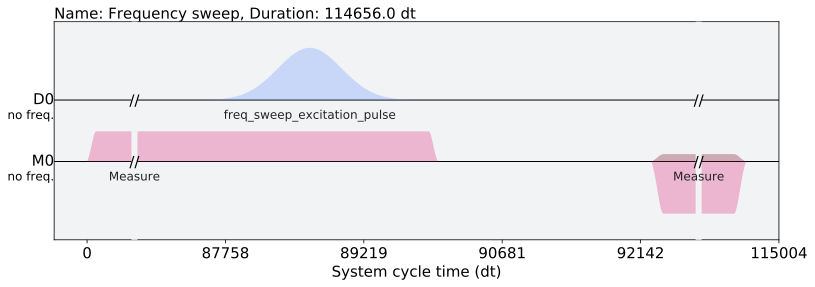

In [310]:
schedule_drawing, job_assumbly = ac_starkshift(0.2, frequencies05_7, 20)
schedule_drawing #prints out the schedule of interest

In [ ]:
Example of how a job was run:
amplitude = 0.5
cavity_drive_time = 7 #in units of us
cavity_ringdown_time = 7
schedule_drawing, job_assumbly = ac_starkshift(amplitude, frequencies05_7, cavity_drive_time, cavity_ringdown_time)

In [ ]:
job = backend.run(job_asseumbly)

In [ ]:
print(job.job_id())

I manually generated the jobs for the different cavity drive and ringdown times and stored the job_ids

The jobs are seen above where I plotted the figures

## Next, I did the same thing but now changed the amplitude for a fixed cavity ringdown and drive time 

In [ ]:
#Now the frequencies are different as well:
frequenciesamp0 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9, spread = 32*MHz)
frequenciesamp01 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 5*MHz, spread = 32*MHz)
frequenciesamp02 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 19*MHz, spread = 32*MHz)
frequenciesamp03 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 42*MHz, spread = 32*MHz)
frequenciesamp04 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 70*MHz, spread = 32*MHz)
frequenciesamp05 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 100*MHz, spread = 32*MHz)
frequenciesamp06 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 125*MHz, spread = 32*MHz)
frequenciesamp07 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 150*MHz, spread = 32*MHz)
frequenciesamp08 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 167*MHz, spread = 32*MHz)
frequenciesamp09 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 187*MHz, spread = 32*MHz)
frequenciesamp1 = get_frequency(amplitude, linear_scaling = 0, center_frequency = 4.972e9 - 193*MHz, spread = 32*MHz)

In [296]:
amplitudes = np.linspace(0, 1, 11)
frequenciesamp_all = [frequenciesamp0, frequenciesamp01, frequenciesamp02, frequenciesamp03, frequenciesamp04, 
                     frequenciesamp05, frequenciesamp06, frequenciesamp07, frequenciesamp08, frequenciesamp09,
                     frequenciesamp1]

In [ ]:
Example of how a job was run:
    
index_to_run = 0
amplitude = amplitudes[index_to_run]
frequency_list = frequenciesamp_all[index_to_run]
cavity_drive_time = 10 #in units of us
cavity_ringdown_time = 10
schedule_drawing, job_assumbly = ac_starkshift(amplitude, frequency_list, cavity_drive_time, cavity_ringdown_time)

In [ ]:
job = backend.run(job_asseumbly)

In [ ]:
print(job.job_id())

## Next, I can run the jobs to make all of the plot with outlier plots

In [ ]:
First, you can look at what the schedule does for a job:
    

Time in dt after cavity drive:  45008
Time in dt before measurment (after ringdown):  135008
total job time:  157408


C:\Users\marti\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


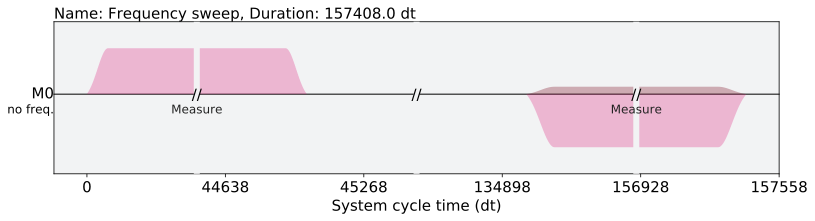

In [304]:
cavity_amplitude = 0.3
scheduleplot, assembly_for_job = ac_starkshift_no_qubit(cavity_amplitude, cavity_pulse_length = 10,  
                                                        ringdown_time = 20, num_shots = 1024*8, wait_time = 0)
scheduleplot

To actually run these jobs:

In [ ]:
all_jobs_running = []  #Make a folder to store the job_ids

In [ ]:
for i, amp in enumerate([0.65]*15):   #will do 15 jobs at apmlitude 0.65 cavity drive time. 
    job_id = starting_jobs(amp, 1024*8, i%5, cavity_drive = 10, cavity_ringdown_time = 20, 
                           wait_time = 0, lowpower= False)  #because you only do 5 jobs at a time, 
    all_jobs_running.append(job_id)     #if you are in the fifth job it will monitor it and not submit until it is done

In [ ]:
print(all_jobs_running)  #to get the job_ids out

## Finally, I did some tests with different measurement pulses to see if they had an effect. 
## Uses the exact same setup except now in the starting job function you set lowpower = True

In [ ]:
all_jobs_running = []  #Make a folder to store the job_ids

In [ ]:
for i, amp in enumerate([0.65]*15):   #will do 15 jobs at apmlitude 0.65 cavity drive amplitude. 
    job_id = starting_jobs(amp, 1024*8, i%5, cavity_drive = 10, cavity_ringdown_time = 20, 
                           wait_time = 0, lowpower= True)  #because you only do 5 jobs at a time, 
    all_jobs_running.append(job_id)     #if you are in the fifth job it will monitor it and not submit until it is done

In [ ]:
print(all_jobs_running)  #to get the job_ids out